<a href="https://colab.research.google.com/github/guiOsorio/Learning_NLP/blob/master/theoffice_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Data Cleaning / Preprocessing

In [2]:
# https://www.kaggle.com/datasets/nasirkhalid24/the-office-us-complete-dialoguetranscript?resource=download
theoffice = pd.read_csv('lines.csv')
print(len(theoffice))
theoffice.head()

54626


,season,episode,title,scene,speaker,line,Unnamed: 6
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,NaN
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",NaN
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,NaN
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",NaN
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",NaN


In [3]:
theoffice_nonas = theoffice[~theoffice['Unnamed: 6'].isna()]
theoffice_nonas['line'] = theoffice_nonas['line'] + ',' + theoffice_nonas['Unnamed: 6']
theoffice_nonas.head()

<ipython-input-3-e650b148abe0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theoffice_nonas['line'] = theoffice_nonas['line'] + ',' + theoffice_nonas['Unnamed: 6']


,season,episode,title,scene,speaker,line,Unnamed: 6
3505,2,8,Performance Review,565,Jan,"I'm good, how are you?",how are you?
3645,2,8,Performance Review,578,Jan,"I'm heading back to New York, Alan and I will ...",Alan and I will conduct your performance revi...
3666,2,8,Performance Review,579,Michael,Jan is not in a place where she feels she can ...,I'm good. I can go home now.
3913,2,9,E-Mail Surveillance,610,Kelly,"I'm sorry guys, can we please not talk about p...",can we please not talk about paper? There's g...
8711,3,6,Diwali,1489,Pam,"You say one more word, I'm stopping the car.",I'm stopping the car.


In [4]:
theoffice_nas = theoffice[theoffice['Unnamed: 6'].isna()]
theoffice = pd.concat([theoffice_nonas, theoffice_nas])
theoffice = theoffice.sort_index()
theoffice = theoffice.loc[:, theoffice.columns != 'Unnamed: 6']
print(len(theoffice))
theoffice.head()

54626


,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."


In [5]:
theoffice.isnull().values.any()

False

In [6]:
# PLAN:
# 1. Train custom vectors with Word2Vec and explore results
    # https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
# 2. Train custom vectors with GloVe and explore results
    # https://towardsdatascience.com/transfer-learning-with-glove-word-vectors-7652456ae269
# 3. Build model to predict 'speaker' based on 'line'

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

nlp.pipe_names
# nlp.pipe_labels['tagger']

# Named entity recognition
  # -> identifying entities in text (like company, person, etc)
# Stemming
  # -> reducing related words into a base word - reduced version doesn't need to be an actual word (history and historical become histori)
  # useful in tasks such as sentiment analysis or identifying spam - tasks where recognition but not a text output is required
# Lemmatization
  # -> reducing related words into its actual base word (history and historical become history)
  # useful in tasks such as chatbots, where an actual text output that makes sense is required
# Tokenization
  # -> turning words into tokens
# Part-of-speech tagging
  # -> predict part-of-speech for each token (verb, noun, etc)
# Dependency parsing
  # -> examining dependencies of sentences to determine its grammatical structure

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [8]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [9]:
# Remove non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in theoffice['line'])

In [10]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.1 mins


In [11]:
# Cleaned up text without NAs and duplicates
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(29243, 1)

In [12]:
from gensim.models.phrases import Phrases, Phraser # to detect common phrases

In [13]:
# split lines into list of words
sent = [row.split() for row in df_clean['clean']]
sent[:2]

[['right', 'jim', 'quarterly', 'look', 'good', 'thing', 'library'],
 ['oh', 'tell', 'close']]

In [14]:
# detect common phrases (bigrams) and join them together using a '_'
# for example, if toy store happens a lot, they will be joined together as one token 'toy_store'
# this is used to generate bigrams to reduce memory comsumption of the model
phrases = Phrases(sent, min_count=30, progress_per=1000)
bigram = Phraser(phrases)

# transform the corpus based on the bigrams detected
sentences = bigram[sent]

In [15]:
# dict with token as key and how many times it shows up as the value
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))

# show most common words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

14004


['know', 'like', 'oh', 'think', 'go', 'want', 'right', 'good', 'okay', 'get']

In [16]:
word_freq['dunder_mifflin']

272

## Word2Vec

In [17]:
import multiprocessing

from gensim.models import Word2Vec

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [19]:
# Declare Word2Vec model
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [20]:
# Build the vocab
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [21]:
# Train model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.58 mins


In [22]:
# make model more memory-efficient since it will not be trained again
# w2v_model.init_sims(replace=True)

## Exploring Results

In [23]:
w2v_model.wv.most_similar(positive=["michael_scott"])

[('regional_manager', 0.992335319519043),
 ('paper_company', 0.9920587539672852),
 ('dwight_schrute', 0.9895186424255371),
 ('introduce', 0.9887926578521729),
 ('dunder_mifflin', 0.9871901869773865),
 ('david_wallace', 0.9829604029655457),
 ('product', 0.9822812080383301),
 ('speak', 0.9817529916763306),
 ('supply', 0.9813931584358215),
 ('owner', 0.9809973239898682)]

In [24]:
w2v_model.wv.most_similar(positive=["pam"])

[('receptionist', 0.9916887879371643),
 ('kinda', 0.9908608198165894),
 ('pretty', 0.9905630350112915),
 ('sure', 0.9904042482376099),
 ('weird', 0.9903406500816345),
 ('saturday', 0.990048885345459),
 ('probably', 0.9900290966033936),
 ('nervous', 0.9899731874465942),
 ('upset', 0.9899448156356812),
 ('absolutely', 0.9897222518920898)]

In [25]:
w2v_model.wv.similarity("paper", "dunder_mifflin")

0.9731362

In [26]:
w2v_model.wv.similarity("michael", "boss")

0.9832987

In [27]:
w2v_model.wv.doesnt_match(['jim', 'pam', 'creed'])

/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'creed'

In [28]:
w2v_model.wv.doesnt_match(['angela', 'kevin', 'jan'])

'jan'

In [29]:
w2v_model.wv.most_similar(positive=["woman", "dwight"], negative=["angela"], topn=3)

[('tell', 0.9711778163909912),
 ('way', 0.9708979725837708),
 ('think', 0.9703617095947266)]

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


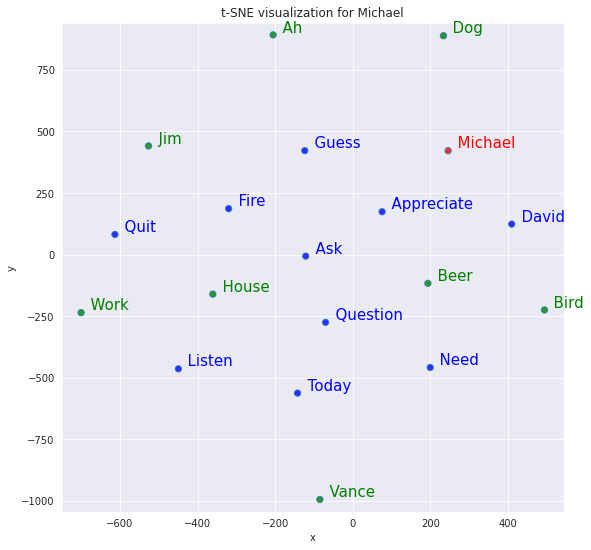

In [32]:
tsnescatterplot(w2v_model, 'michael', ['dog', 'bird', 'ah', 'jim', 'vance', 'beer', 'work', 'house'])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


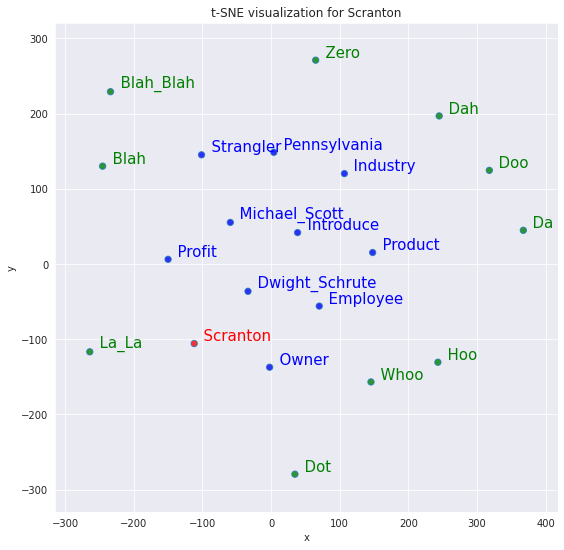

In [33]:
tsnescatterplot(w2v_model, 'scranton', [i[0] for i in w2v_model.wv.most_similar(negative=["scranton"])])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


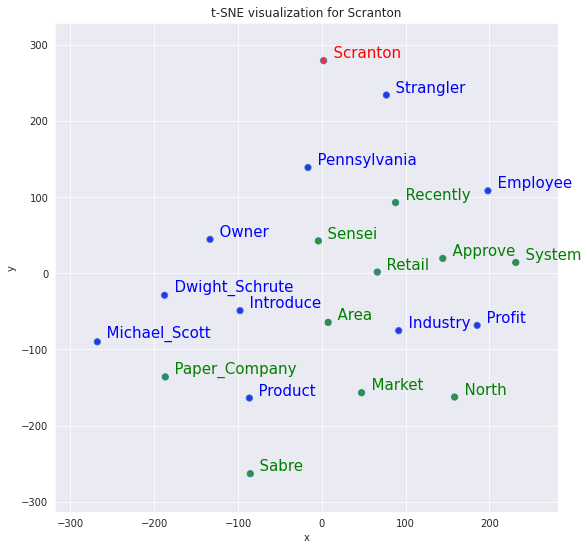

In [34]:
tsnescatterplot(w2v_model, "scranton", [t[0] for t in w2v_model.wv.most_similar(positive=["scranton"], topn=20)][10:])

## GloVe

In [35]:
import sys
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [36]:
# convert glove vectors into gensim word2vec format
glove_file = datapath('/content/glove.6B.100d.txt') # stores the global path to the specified file
tmp_file = get_tmpfile("test_word2vec.txt") # generate temp file
_ = glove2word2vec(glove_file, tmp_file) # convert glove vectors to word2vec format -> store in tmp_file
glove_vectors = KeyedVectors.load_word2vec_format(tmp_file) # contains word2vec format of glove vectors

In [37]:
# toy word2vec model was trained above (under Word2Vec section) -> (w2v_model)
glove_w2v_model = w2v_model
total_examples = glove_w2v_model.corpus_count

In [38]:
# add GloVe's vocabulary & weights
glove_w2v_model.build_vocab([list(glove_vectors.vocab.keys())], update=True)

# train on your data
glove_w2v_model.train(sentences, total_examples=total_examples, epochs=glove_w2v_model.epochs)
glove_w2v_model = glove_w2v_model.wv

In [39]:
glove_w2v_model.wv.most_similar(positive=["michael_scott"])

<ipython-input-39-24029aa79e66>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.most_similar(positive=["michael_scott"])


[('paper_company', 0.813092827796936),
 ('regional_manager', 0.8019026517868042),
 ('dwight_schrute', 0.7182952165603638),
 ('dunder_mifflin', 0.6925348043441772),
 ('david_wallace', 0.6607251167297363),
 ('director', 0.6520363688468933),
 ('hello', 0.651871383190155),
 ('introduce', 0.6368623971939087),
 ('hi', 0.6306074261665344),
 ('miner', 0.6195218563079834)]

In [40]:
glove_w2v_model.wv.most_similar(positive=["pam"])

<ipython-input-40-86b4f34581f5>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.most_similar(positive=["pam"])


[('receptionist', 0.6344768404960632),
 ('beesly', 0.634421706199646),
 ('brian', 0.608390212059021),
 ('kathy', 0.5957479476928711),
 ('awhile', 0.5937021970748901),
 ('pamela', 0.5790366530418396),
 ('cynthia', 0.5761419534683228),
 ('voicemail', 0.5686982870101929),
 ('jim', 0.5595781803131104),
 ('damnit', 0.5549526810646057)]

In [41]:
glove_w2v_model.wv.similarity("paper", "dunder_mifflin")

<ipython-input-41-6b37837070d6>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.similarity("paper", "dunder_mifflin")


0.4789576

In [42]:
glove_w2v_model.wv.similarity("michael_scott", "boss")

<ipython-input-42-736f35c6001b>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.similarity("michael_scott", "boss")


0.53560895

In [43]:
glove_w2v_model.wv.doesnt_match(['jim', 'pam', 'creed'])

<ipython-input-43-ce264f7d233d>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.doesnt_match(['jim', 'pam', 'creed'])
/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'creed'

In [44]:
glove_w2v_model.wv.doesnt_match(['angela', 'kevin', 'jan'])

<ipython-input-44-aa5c1aae8961>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.doesnt_match(['angela', 'kevin', 'jan'])


'jan'

In [45]:
glove_w2v_model.wv.most_similar(positive=["angela", "dwight"], negative=["man"], topn=3)

<ipython-input-45-74e92558e627>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_w2v_model.wv.most_similar(positive=["angela", "dwight"], negative=["man"], topn=3)


[('shy', 0.5625127553939819),
 ('damnit', 0.5405657291412354),
 ('kathy', 0.5115801095962524)]

<ipython-input-31-605672ffd9dd>:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
<ipython-input-31-605672ffd9dd>:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  close_words = model.wv.most_similar([word])
<ipython-input-31-605672ffd9dd>:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd_score[0]])
<ipython-input-31-605672ffd9dd>:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  wrd_vector = model.wv.__getitem__([wrd])
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:7

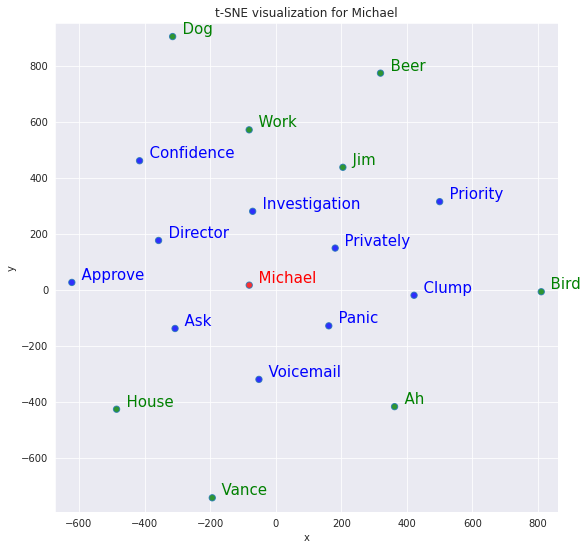

In [46]:
tsnescatterplot(glove_w2v_model, 'michael', ['dog', 'bird', 'ah', 'jim', 'vance', 'beer', 'work', 'house'])